# Covid19 Risk Groups based on Mortality Rate and Demographic Characteristics

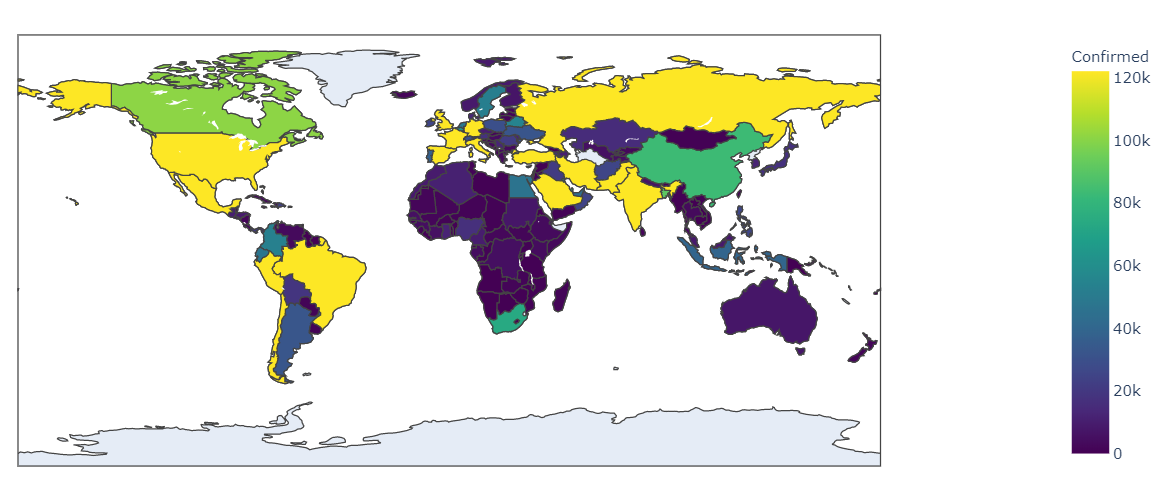

### The coronavirus disease(Covid-19) is an ongoing pandemic caused by severe acute           respiratory syndrome coronavirus 2(SARS‑CoV‑2. The outbreak was firstly detected in Wuhan,          China,and The World Health Organisation(WHO) declared the outbreak an international health            emergency. As of 29 March 2020, more than 677,622 cases of COVID-19 have been reported in 199          countries and territories. As a data scientist, I can help countries and global health institutions to take the necessary steps to fight against the outbreak. In this kernel, my primary objective is to find subgroups among the countries with similar COVID-19 mortality rates,healthcare quality index,and  demographic characteristics such as population and average age. In this way, countries in the same      groups can help each other and make similar provisions against COVID-19.

##  I hope you find this kernel enjoyable and useful
## Your upvotes would be highly appreciated

### Additional Datasets used in the task : 
‘Population by Country -2020’ https://www.kaggle.com/tanuprabhu/population-by-country-2020

‘Health Care Index by Country 2020’ https://www.numbeo.com/health-care/rankings_by_country.jsp --- HTML data



In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
import sklearn.mixture
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from fbprophet.plot import plot_plotly   ###  !pip install pycountry-convert
import pycountry_convert as pc

## Preprocessing Stage

In [ ]:

total = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv')

In [ ]:
total_last = total[total['ObservationDate'] == '06/15/2020']
total_last.head()

In [ ]:
total_last.drop(['SNo','ObservationDate','Last Update'],axis = 1,inplace = True)
# Organise the column names
total_last= total_last.rename(columns={"Province/State":"state","Country/Region": "country"})
# Fill null values in state column with blank 
total_last[['state']] = total_last[['state']].fillna('')
# Fill null values in Confirmed, Deaths and Recovered columns with zero
total_last[['Confirmed', 'Deaths', 'Recovered']] = total_last[['Confirmed', 'Deaths', 'Recovered']].fillna(0)
# Notice there are some instances which have zero latitude and longtitude. These are ships.
total_last.head()

In [ ]:
# Data types of features in the dataframe
total_last.dtypes

In [ ]:
#Check the null values in the dataset
sns.heatmap(total_last.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [ ]:
# Total country which represents total Confirmed, deaths, recovered and active cases for each country
total_country = total_last.groupby('country')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
total_country.head()


In [ ]:
total_country.loc[total_country['country'] == "US", "country"] = "USA"
total_country.loc[total_country['country'] == 'Korea, South', "country"] = 'South Korea'
total_country.loc[total_country['country'] == 'Taiwan*', "country"] = 'Taiwan'
total_country.loc[total_country['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
total_country.loc[total_country['country'] == 'UK','country'] = 'United Kingdom'
total_country.loc[total_country['country'] == 'Mainland China','country'] = 'China'


In [ ]:
total_country.head()

In [ ]:
# Population data set
population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
population = population[['Country (or dependency)','Population (2020)', 'Med. Age']]
population.columns= ['country','population','Avrg_age']
population.loc[population['country'] == 'United States', "country"] = "USA"
population.loc[population['country'] == 'Czech Republic (Czechia)', "country"] = 'Czechia'
population.head()

In [ ]:
# Healthcare index data set
health = pd.read_html('https://www.numbeo.com/health-care/rankings_by_country.jsp')
health = health[2]
health = health[['Country', 'Health Care Index']]
health.columns= ['country','healthcare_index']
health.loc[health['country'] == 'United States', "country"] = "USA"
health.loc[health['country'] == 'Czech Republic', "country"] = "Czechia"
health.head()

In [ ]:
# We merge total_country, population and healthcare index data set to find useful clusters in clustering stage
total_country = pd.merge(total_country, population, on='country', how='left',copy = False)
total_country = pd.merge(total_country, health, on='country', how = 'left',copy = False)
# New column is created for clustering stage: Mortality Rate
total_country['Mortality_rate'] = np.round((total_country['Deaths'] / total_country['Confirmed']) *100,2)
total_country.head()

In [ ]:
# However, there are null values in the merged data set. We handle those null values. We replace these with mean values of the dataframe
total_country['Avrg_age'] = total_country['Avrg_age'].fillna(0)
total_country['Avrg_age'] = total_country['Avrg_age'].replace('N.A.', '0')
# Change the datatype of average age column
total_country['Avrg_age'] = total_country['Avrg_age'].astype('int')
total_country['healthcare_index'] = total_country['healthcare_index'].replace(np.nan, total_country['healthcare_index'].mean())
total_country['Avrg_age'] = total_country['Avrg_age'].replace(0, total_country['Avrg_age'].mean())
total_country['Avrg_age'] = total_country['Avrg_age'].replace(np.nan, total_country['Avrg_age'].mean())
total_country['population'] = total_country['population'].replace('N.A.', total_country['population'].mean())
total_country['population'] = total_country['population'].replace(np.nan, total_country['population'].mean())


In [ ]:
total_country.dtypes

In [ ]:
# Change the datatype of healthcare index column
total_country['healthcare_index'] = total_country['healthcare_index'].astype('int')
total_country['Avrg_age'] = total_country['Avrg_age'].astype('int')
total_country['Confirmed'] = total_country['Confirmed'].astype('int')
total_country['Deaths'] = total_country['Deaths'].astype('int')
total_country['Recovered'] = total_country['Recovered'].astype('int')
total_country['population'] = total_country['population'].astype('int')
total_last['Confirmed'] = total_last['Confirmed'].astype('int')
total_last['Deaths'] = total_last['Deaths'].astype('int')
total_last['Recovered'] = total_last['Recovered'].astype('int')
total_country.head()

In [ ]:
# Use pycountry-convert package to assign continent name to each country. But our function didn't assign some countries to continent names
# We assign those countries to 'Others'
# Create dictionary to assing ISO continent name to continents
continents = {
    'EU' : 'Europe',
    'SA': 'South America', 
    'OC': 'Australia',
    'AS': 'Asia',
    'AF': 'Africa',
    'NA': 'North America',
    'Unknown' : 'Others'
}
# All of the countries in the data set
countries = total_country['country'].unique()
def get_continent(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'Unknown'

#Insert continent column to dataframe
total_country.insert(0,"continent", [continents[get_continent(country)] for country in countries])



In [ ]:
# Pycountry library doesn't assign China and Burma to Asia. Thus, I assign them to Asia manually
total_country['continent'][total_country['country'] == 'Burma'] = 'Asia'
total_country['continent'][total_country['country'] == 'China'] = 'Asia'


## Exploratory Data Analysis Stage

In [ ]:
# Countries with Confirmed Cases
figure = px.choropleth(total_country, locations="country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="country",  range_color=[1,122000],
                    color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Countries with Confirmed Cases')
figure.show()

In [ ]:
# Size of the circle represents the number of the confirmed cases, whereas colour represents the number of the death cases
fig = px.scatter_geo(total_country, locations="country",locationmode='country names', color="Deaths",
                     hover_name="country", size="Confirmed",hover_data = ['country','Deaths','Mortality_rate','Confirmed'],
                     projection="natural earth",title='Countries with Confirmed and Death Cases')
fig.show()

In [ ]:
# Size of the circle represents the number of the confirmed cases, whereas colour represents the number of the recovered cases
fig = px.scatter_geo(total_country, locations="country",locationmode='country names', color="Recovered",
                     hover_name="country", size="Confirmed",hover_data = ['country','Recovered', 'Confirmed'],
                     projection="natural earth",title='Countries with Confirmed and Recovered Cases')
fig.show()

In [ ]:
# Countries with death cases
fig = px.treemap(total_country, path=['continent','country'], values='Deaths',
                 height=600,title='Number of Death Cases',color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [ ]:
# Continents with Confirmed Cases
total_continent= total_country.groupby('continent')['continent', 'Confirmed'].sum().reset_index()
fig = px.bar(total_continent.sort_values('Confirmed', ascending=False)[::-1], x='Confirmed', y='continent',color_discrete_sequence=['#84DCC6'],
             title='Continents with Confirmed Cases', text='Confirmed', height=500, orientation='h')
fig.show()

In [ ]:
#Confirmed cases in Europe
europe = total_country[total_country['continent'] == 'Europe']
fig = px.choropleth(europe, locations="country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="country", 
                     color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Confirmed cases in Europe', scope='europe', height=800)
fig.show()

In [ ]:
# Continents with Death Cases
total_continent1= total_country.groupby('continent')['continent', 'Deaths'].sum().reset_index()
fig = px.bar(total_continent1.sort_values('Deaths', ascending=False)[::-1], x='Deaths', y='continent',color_discrete_sequence=['#D63230'],
             title='Continents with Deaths Cases', text='Deaths', height=500, orientation='h')
fig.show()

In [ ]:
# Death Cases in Europe
fig = px.choropleth(europe, locations="country", 
                    locationmode='country names', color="Deaths", 
                    hover_name="country", 
                     color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Death cases in Europe', scope='europe', height=800)
fig.show()

In [ ]:
fig = px.scatter(total_country, x="Confirmed", y="Deaths", size="population", color="continent",
           hover_name="country", log_x=True, log_y = True, size_max=60, title = 'Death and Confirmed Cases Worldwide')
fig.show()

In [ ]:
# Death Cases in Asia
asia = total_country[total_country['continent'] == 'Asia']
fig = px.choropleth(asia, locations="country", 
                    locationmode='country names', color="Deaths", 
                    hover_name="country", 
                     color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Death cases in Asia', scope='asia', height=800)
fig.show()

In [ ]:
# Countries with death cases
USA= total_last[total_last['country'] == 'US']
fig = px.treemap(USA, path=['country','state'], values='Deaths',
                 height=600,title='Number of Death Cases in USA',color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [ ]:
Germany = total_last[total_last['country'] == 'Germany']
fig = px.bar_polar(Germany, r="Confirmed", theta="state", title = 'Number of Death and Confirmed Cases in Germany',color = 'Deaths',template="plotly_dark",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

## Proposed Method 

### Clustering + Future Forecasting

In [ ]:
# In clustering part we will use first 50 countries with highest confirmed case numbers. 
total_50 = total_country.sort_values(by = 'Confirmed', ascending = False).head(50)

In [ ]:
# Feature Correlation map
sns.heatmap(total_50.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Feature selection respect to correlation map
data = total_50[['Mortality_rate','Avrg_age','population','healthcare_index']]

In [ ]:
# Describe the dataframe to see variation of the data. Variation in population is high. We must normalize it. 
data.describe()

### Clustering

### Kmeans

In [ ]:
# Standardisation the data because groups are defined based on the distance between points
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pd.DataFrame(data_scaled).describe()

In [ ]:
# calculate the sum of squares of the distances of each data points which represents countries
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(data_scaled)
    wcss.append(y_means.inertia_)
# Plot WCSS to find the number of clusters
plt.plot(range(1,11), wcss)
plt.xlabel("No. of clusters")
plt.ylabel(" Within Cluster Sum of Squares")
plt.show()

In [ ]:
# Decide the number of clusters. The coefficient varies between -1 and 1. The best value is 1
silhoutte=[]
for i in range(3,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(data_scaled)
    data_cluster = y_means.predict(data_scaled)
    silhoutte.append(sklearn.metrics.silhouette_score(data_scaled,data_cluster))
#Plot silhoutte score to find the number of clusters
plt.plot(range(3,11), silhoutte)
plt.xlabel("No. of clusters")
plt.ylabel("Silhoutte Score for each cluster")
plt.show()

In [ ]:
# Initialise the model with the number of clusters
k_meansmodel = sklearn.cluster.KMeans(6,init='k-means++')
# Fit the model
k_meansmodel.fit(data_scaled)
# Predict the clusters
data_cluster = k_meansmodel.predict(data_scaled)

In [ ]:
# Visualisation of the clusters is not easy becasue our data have more than 2 dimensions
plt.figure(figsize=(8, 4))
# Mortality rate vs average age of the countries
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c= data_cluster, cmap = 'rainbow')
plt.xlabel('Mortality rate')
plt.ylabel('Average Age')
plt.title('Visualisation of risk groups based on mortality rate and average age with K-Means clustering')
plt.show()

In [ ]:
# We grouped countries into 6 groups respecto K-means clustering
risk_group= pd.DataFrame()
risk_group["country"]=total_50["country"]
risk_group["risk_group"]=data_cluster
for group in range(0,6):
    countries=risk_group.loc[risk_group['risk_group']==group]
    country_list= list(countries['country'])
    print("Group", group, ":", country_list)

In [ ]:
risk_group['Mortality_rate'] = data_scaled[:,0]
risk_group['Avrg_age'] = data_scaled[:,1]
risk_group['population'] = data_scaled[:,2]
risk_group['healthcare_index'] = data_scaled[:,3]



In [ ]:
risk_group["risk_group"] = risk_group["risk_group"].astype(str)
fig = px.scatter(risk_group, x="Mortality_rate", y="Avrg_age", color="risk_group", hover_name = 'country',category_orders={"risk_group": ["0", "1", "2", "3", "4","5"]},width = 600, height = 400 )
fig.update_layout(
    title=" Visualisation of risk groups based on mortality rate and average age with K-Means clustering",
    xaxis_title="Mortality rate",
    yaxis_title="Average Age",
    font=dict(
        size=10,
        color="#7f7f7f"))
fig.show()